# Identifying AI Software

Building an identification mechanism to tag and classify open-source software on Github as "AI-related." Our methodology can be broken down into the following steps: 

1. Embedding all the open source software into a common metric space. 
2. Identifying a small set of "ground truth" AI software, software that we deem to definitely be AI.
3. Building a classifier such that we can label all the open source software on Github as "AI" or "not-AI". 

## Identifying AI Software

The first step in identifying AI software is to identify a technique to identify _some_ software as AI. Our process:

1. Identify several "top" AI conferences, as recommended by experts. 
2. Create a list of all the paper titles from those conferences. 
3. Search for repositories that contain _exact string matches_ with these titles using Github's search API. 
4. Remove repositories that have more than 5 titles (often these are compilations of papers, not software). 
5. Remove titles that are common phrases that seem to match many repos without being references to the papers. To do this, we count the number of words in each title and subtract a penalalization term based on the number of matches it returned in the search (a Gamma distribution whose location parameter is learned). We learn both the penalty parameter and the threshold above which we keep the title. Thus, a title of only two of words and only one search hit will be kept, whereas a title of four words and many search hits will be thrown away. We then tune the parameters of the regularization and the decision threshold with a small set (~20) paper titles that we hand label. We ensure a precision score of 1.0, meaning that we have no false positives from our hand-labelled set, and then maximize the recall score. 
6. This reduces the number of titles from 2380 to 1787. 
7. We then collect repositories that have readmes that contain a title from the reduced title list: 2955 repositories.

The readmes from these repositories are then used as a "positive" training set, our ground truth, software that we believe to definitely be AI. 

We have intentionally restricted the conferences to only the top 5 directly related to AI, primarily because several conferences on the list contained papers and talks that were relatively far away from  what we understand to be AI. For example: The International World Wide Web conference.

We have not yet gathered statistics on the coverage we have (repositories/paper for each conference).

Given our classification technique, diminishing returns on the number of papers and repositories identified kicks in very quickly. Given the text from a handful (dozens) of exemplary AI software readmes, one can expect the classification to perform nearly as well as with thousands. Similarly, while the classifier is by design robust to random outliers, if we include many papers that we do _not_ consider core AI, it will fit the data accordingly. 

In [111]:
# !pip install --quiet hdmedians
# !pip install --quiet pymongo[srv,tls]
# !pip install --quiet diskcache
# !pip install --quiet wordcloud

In [151]:
TFIDF = True
MODEL = "tfidf/tfidf_vectorizer"
GITHUB_RESULTS = 'conferences/gh_responses_2.jl'
GITHUB_EMBEDDINGS = 'tfidf/tfidf_embeddings.npz'
# DIMS=200
# EMBEDDINGS_SIZE = int(4131274/2)

# make CONFS a falsey value to return all conferences
# CONFS = ['UAI', 'ICML', 'COLT', 'NIPS', 'AISTATS']
CONFS = False
# CONFS = ['NIPS']

In [119]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from lib.utils import *
from repoman.filter_responses import get_repos_titles
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import OneClassSVM
from scipy.sparse import save_npz, load_npz
from sklearn.externals import joblib
from copy import deepcopy
import json

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
repos = get_repos_titles(GITHUB_RESULTS, CONFS, 12)    

In [121]:
readmes = get_ai_readmes(repos, workers=15)

In [125]:
if TFIDF:
    vectorizer = joblib.load(MODEL)
    vecs = vectorizer.transform(readmes)
else:
    vecs = embed_docs(MODEL, '\n'.join(readmes))

## Results

* 1787/13000 titles of papers (~13.7%) from top AI conferences were identified as "referenced in software repositories"
* Trained classifier on 2955 repositories identified from those papers
* Classified ~11500 / 2.7 million repositories as **Core AI** (0.004%)

## Set nu via Elbow!

In [142]:
nus = np.arange(0.1, .8, 0.05)

In [ ]:
from multiprocessing import Pool

class Predict():
    def __init__(self, vecs, tfidf=False):
        self.vecs = vecs
        self.tfidf = tfidf
        
    def predict(self, nu):
        # get embeddings via model
        if self.tfidf:
            embeddings = load_npz(GITHUB_EMBEDDINGS)
        else:
            embeddings = get_embeddings(GITHUB_EMBEDDINGS, EMBEDDINGS_SIZE, dims=DIMS)
        model = OneClassSVM(nu=nu, gamma=1/1000)
        model = predict_ai(model, self.vecs)
        decs = model.decision_function(embeddings)
        return decs.reshape(-1)

with Pool(8) as pool:
    p = Predict(vecs, tfidf=TFIDF)
    results = pool.map(p.predict, nus)

In [ ]:
np.save('decs/allconfs-{}'.format(MODEL.split('/')[1]), np.array(results))

In [ ]:
d = pd.DataFrame([((r > 0).sum(),i) for r,i in zip(results, nus)], columns = ['amount', 'nu'])
sns.lineplot(data = d, x = 'nu', y = 'amount')

## Compare Embeddings

In [156]:
import os

arrs = [np.load(os.path.join('decs', f)) for f in os.listdir('decs')]

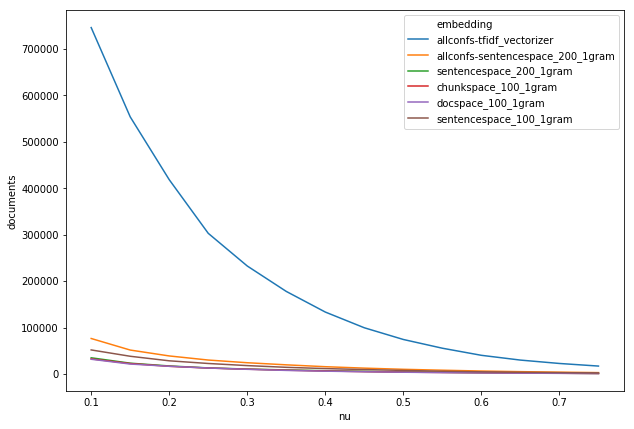

In [157]:
ns = [s.split('.')[0] for s in os.listdir('decs')]

d = pd.concat([pd.DataFrame({'documents': [(p > 0).sum() for p in arrs[i]], 
                         'embedding': ns[i], 
                         'nu': nus}) 
           for i in range(len(ns))])

sns.lineplot(data=d, x='nu', y='documents', hue='embedding')

In [158]:
## PRINT TABLE FOR BIGQUERY JOINING
## NO CAN DO VIA API DUE TO LACK OF ACCESS TO FREE :(

poss = [[np.argwhere(p > 0).reshape(-1) for p in arrs[i]] for i in range(len(ns))]

pos_df = pd.concat([pd.DataFrame({'id': get_ids(poss[i][n]), 'model': ns[i], 'nu': nus[n]}) 
                    for i in range(len(ns))
                   for n in range(len(nus))])

In [159]:
pos_df.to_csv('ai-ids/ids-by-model.csv', index=False)

## Word Cloud of our predicted repositories

Lacking a quantitative process for validation, we can look at examples qualitatively and try to get a sense of the topics in the software we picked. Here is a word cloud created from the picked repositories: 

In [198]:
EXTRA_STOP_WORDS = ['use', 'run', 'project','code', 'library', 'package', 
                    'file', 'files', 'using', 'install', 'data', 'used', 'used', 
                    'set', 'example', 'model', 'like', 'version', 'add', 'new', 'create'
                    'need', 'following']

In [199]:
# TODO: remove numbers in preprocessing?
def word_freqs(docs, vocab = None):

    stop_words = REPO_STOP_WORDS | frozenset(EXTRA_STOP_WORDS)
    # Remove stop words and create word frequencies
    vectorizer = CountVectorizer(stop_words = stop_words, 
                                 max_df = 1.0, 
                                 ngram_range=(1,3), 
                                 vocabulary=vocab, 
                                 max_features=1000) # max_features ignored if vocab is provided
    vecs = vectorizer.fit_transform(docs)
    counts = np.asarray(vecs.sum(0)).reshape(-1)
    di = np.array(vectorizer.get_feature_names())
    
    # Filter low-frequency words to ease work for Wordcloud
    idx = (counts > 100)
    freqs = zip(di[idx], counts[idx])
    return dict(freqs)

In [ ]:
from wordcloud import WordCloud

docs = [get_sentence(p) for p in get_predictions('predictions/ss_100_1gram.txt')]
WordCloud(width=800, height=500).fit_words(word_freqs(docs)).to_file('figures/word-cloud-ss.png').to_image()

In [144]:
from gensim.corpora import Dictionary

gh_dict = Dictionary().load('prepared-readmes/gh-raw-dict')
gh_dict.filter_extremes(no_below=200)
c = TextCorpus()
gh_dict.add_documents([c.preprocess_text(r) for r in readmes])

In [176]:
for i,f in enumerate(gh_dict.items()):
    pass

gh_freqs = {gh_dict.id2token[k]:v for k,v in gh_dict.dfs.items()}

In [204]:
WordCloud(width=800, height=500).fit_words({k:v for k,v in gh_freqs.items() if k not in EXTRA_STOP_WORDS}).to_file('figures/word-cloud-gh.png')

## Comparison with TF-IDF

It is useful to compare to a baseline embedding of a TF-IDF matrix. Using the same parameters, the TF-IDF model predicts many more documents, which to the eye look very noisy. By being more aggressive on the tuning of the classification model (allowing up to 60% of original repositories to be excluded), we achieve a comparable number of documents (~10k). 

A wordcloud representing the common words in these repositories shows that these 10k repositories appear to be much more general than those achieved with the StarSpace embeddings: 

In [ ]:
# create_dict('prepared-readmes/repos.txt', save='prepared-readmes/gh-raw-dict')

#### Load and run

In [44]:
ss_docs = [get_sentence(p) for p in get_predictions('predictions/ss_100_1gram.txt')]
tfidf_docs = [get_sentence(p) for p in get_predictions('predictions/tfidf-predictions-60.txt')]

In [47]:
ss_docs = frozenset(ss_docs)
tfidf_docs = frozenset(tfidf_docs)

In [218]:
1 - len(frozenset(readmes) - ss_docs) / len(readmes)

0.09616858237547887

In [ ]:
list(tfidf_docs - ss_docs)[0:10]

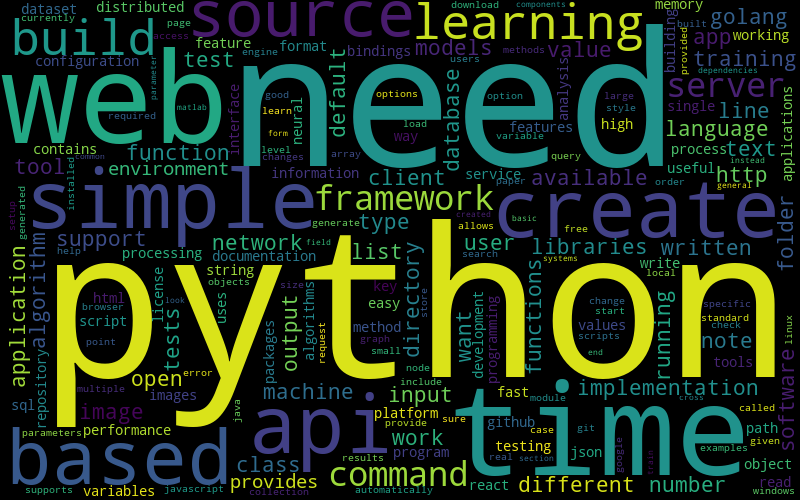

In [194]:
WordCloud(width=800, height=500).fit_words(word_freqs(list(tfidf_docs - ss_docs), gh_dict.token2id)).to_image()

In [ ]:
list(ss_docs - tfidf_docs)[0:10]

In [70]:
f = word_freqs(list(tfidf_docs - ss_docs))
sorted(f.items(), key=lambda t: -t[1])[0:20]

[('model', 9105),
 ('like', 7531),
 ('python', 7426),
 ('need', 5970),
 ('time', 5882),
 ('web', 5791),
 ('simple', 5783),
 ('api', 5643),
 ('create', 5643),
 ('based', 5638),
 ('source', 5543),
 ('following', 5454),
 ('learning', 5398),
 ('build', 5379),
 ('framework', 5315),
 ('command', 5213),
 ('server', 5087),
 ('make', 5051),
 ('implementation', 4899),
 ('language', 4864)]

In [138]:
f = word_freqs(list(ss_docs - tfidf_docs))
ss_words,_ = zip(*sorted(f.items(), key=lambda t: -t[1])[0:15])

In [139]:
f = word_freqs(list(tfidf_docs - ss_docs))
tfidf_words,_ = zip(*sorted(f.items(), key=lambda t: -t[1])[0:15])

In [140]:
ss_words = frozenset(ss_words)
tfidf_words = frozenset(tfidf_words)

In [196]:
ss_words - tfidf_words

frozenset({'algorithm',
           'analysis',
           'function',
           'image',
           'models',
           'number',
           'py',
           'results',
           'test',
           'training',
           'version'})

In [142]:
tfidf_words - ss_words

frozenset({'api',
           'build',
           'command',
           'create',
           'framework',
           'learning',
           'need',
           'server',
           'simple',
           'source',
           'web'})

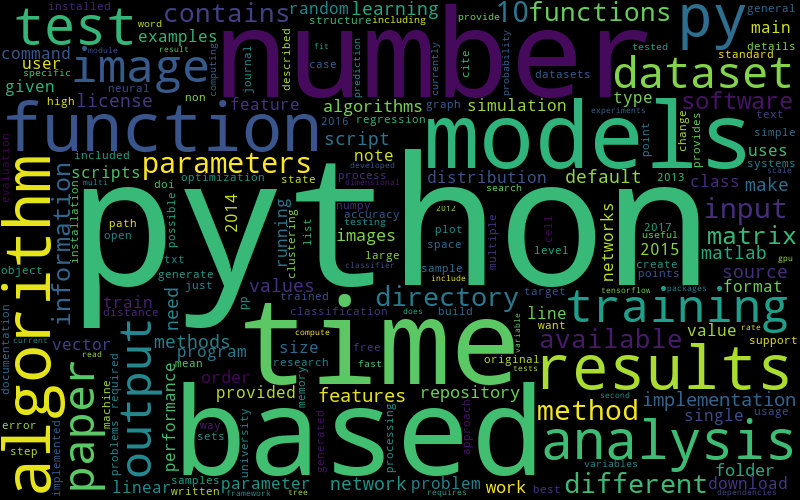

In [202]:
WordCloud(width=800, height=500, relative_scaling=1).fit_words(word_freqs(list(ss_docs - tfidf_docs))).to_image()

In [60]:

from gensim.corpora import Dictionary
gh_dict = Dictionary().load('prepared-readmes/gh-raw-dict')

In [62]:
from gensim.corpora.textcorpus import TextCorpus
gh_dict.filter_extremes(no_below=200)
c = TextCorpus()
gh_dict.add_documents([c.preprocess_text(r) for r in readmes])

In [102]:
from lib import tfidf

svm = OneClassSVM(kernel='rbf', nu = .6, gamma = 1/1000)
tfidf_embeddings,vectorizer = tfidf.embed(readmes, gh_dict) # adds all-readmes to readmes automatically

In [103]:
save_npz('tfidf_embeddings', tfidf_embeddings)

In [ ]:
joblib.dump(vectorizer, 'tfidf_vectorizer')

In [ ]:
tfidf.make_predictions(svm, tfidf_embeddings, readmes, save='predictions/tfidf-predictions-60.txt')

In [41]:
from wordcloud import WordCloud

docs = [get_sentence(p) for p in get_predictions('predictions/tfidf-predictions-60.txt')]

In [ ]:
docs[10:20]

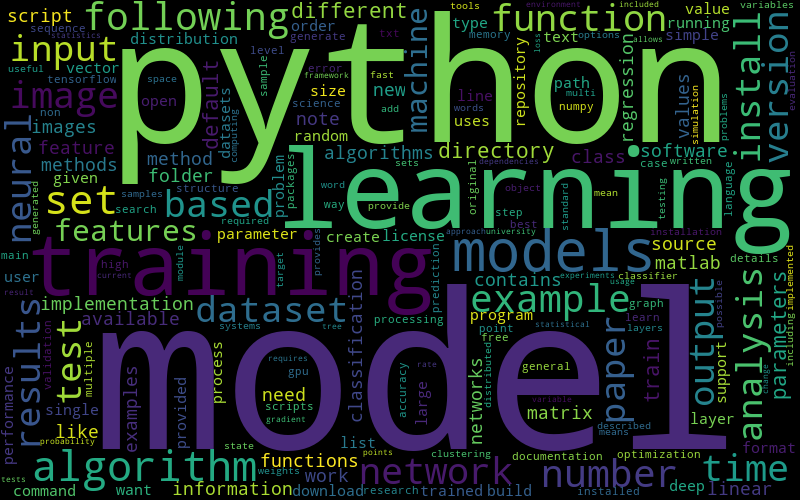

In [36]:
WordCloud(width=800, height=500).fit_words(word_freqs(docs, gh_dict.token2id)).to_image()

In [ ]:
############# WHY THIS THE SAME??????????? 
##########################################
##########################################

In [47]:
with open('predictions/cs_100_1gram.txt', 'r') as f:
    q = [int(i.strip()) for i in f.readlines()]

In [60]:
ds_weights = pd.read_csv('ss/docspace_100_1gram.tsv', sep='\t', header=None, index_col = 0)
cs_weights = pd.read_csv('ss/chunkspace_100_1gram.tsv', sep='\t', header=None, index_col = 0)

In [105]:
ds_weights.drop_duplicates(inplace=True)
cs_weights.drop_duplicates(inplace=True)

In [106]:
x = cs_weights[cs_weights.index.isin(ds_weights.index)]

In [107]:
y = ds_weights[ds_weights.index.isin(x.index)]

In [109]:
x = x.sort_values(0)
y = y.sort_values(0)

In [ ]:
x.index.shape, y.index.shape